In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive')
import helper as hp

# MLP

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, BatchNormalization, Dropout, Flatten, Activation
from keras.optimizers import Adam, RMSprop, SGD, Adagrad, Adadelta, Adamax, Nadam
from tensorflow.keras.layers import Input, Flatten, Dense, Concatenate, Embedding, BatchNormalization, Dropout
from keras.metrics import SensitivityAtSpecificity
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, Callback
from keras.utils import np_utils
import keras.backend as K
from keras import Model
import datetime

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc, roc_auc_score
from itertools import cycle


In [5]:
from keras.datasets import mnist

(x_train, y_train) , (x_test, y_test) = mnist.load_data()
train_morpho = pd.read_csv("/content/drive/MyDrive/train-morpho.csv")
test_morpho = pd.read_csv("/content/drive/MyDrive/t10k-morpho.csv")

class_names = ['0','1','2','3','4','5','6','7','8','9']


11490434/11490434 [==============================] - 1s 0us/step


# EDA

,index,area,length,thickness,slant,width,height
0,0,107.3125,50.266504,2.460658,0.231074,14.539572,19.849054
1,1,123.2500,51.198485,2.616601,0.331858,15.387810,19.341053
2,2,78.3750,45.927670,1.891592,-0.212196,20.479656,19.114880
3,3,67.3125,22.849242,2.919769,0.509185,5.358179,19.724599
4,4,91.1875,46.284271,2.247425,0.007590,13.275437,19.527523


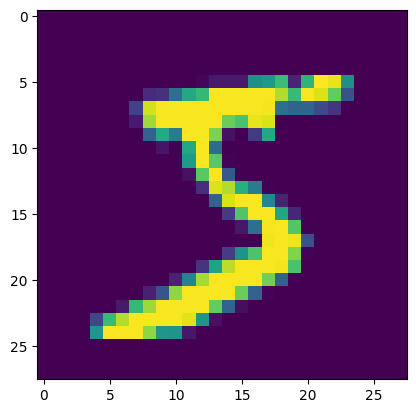

5

In [6]:
display(train_morpho.head())
plt.imshow(x_train[0])
plt.show()
y_train[0]

### Let's see some examples of the classes:

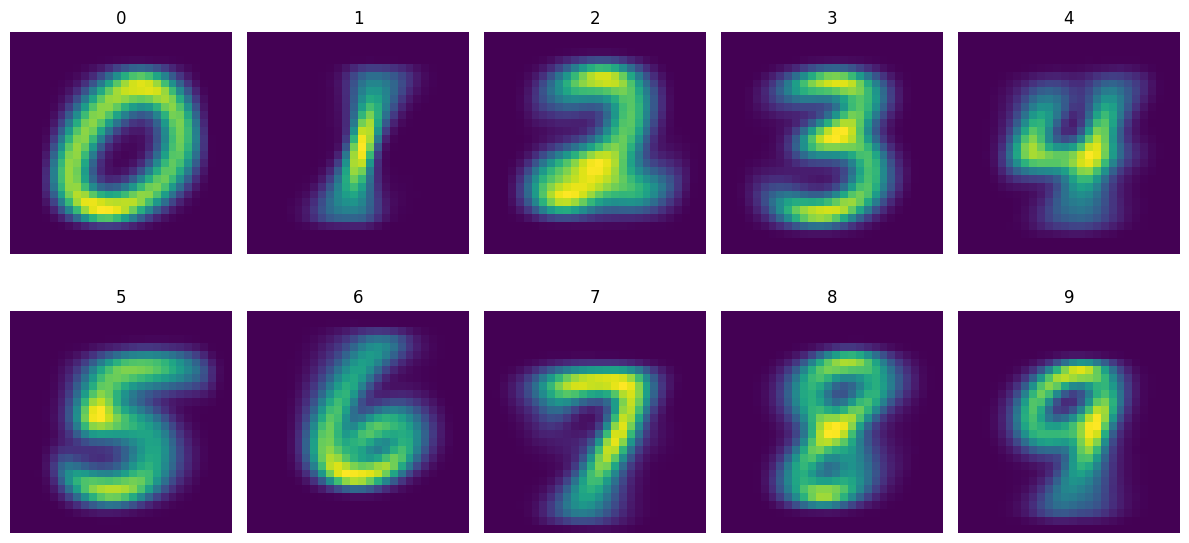

In [7]:
class_intensity = []
for i in set(y_train):
    class_intensity += [x_train[np.where(y_train == i)].sum(axis=0)]

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i in range(10):
    ax = axes[i]
    ax.imshow(class_intensity[i])
    ax.axis('off')
    title = class_names[i]
    ax.set_title(title)

plt.tight_layout()

plt.show()

### Histograms of inclination

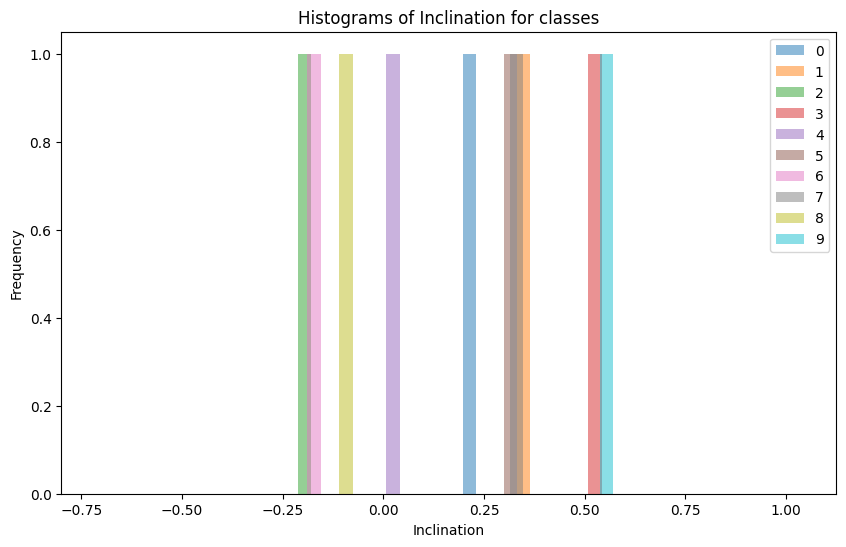

In [8]:
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.hist(train_morpho[train_morpho['index'] == i]['slant'], bins=30, alpha=0.5, label=str(i))
plt.xlabel('Inclination')
plt.ylabel('Frequency')
plt.title('Histograms of Inclination for classes')
plt.legend()
plt.show()

### Scatter plots between inclination and morphologic descriptors

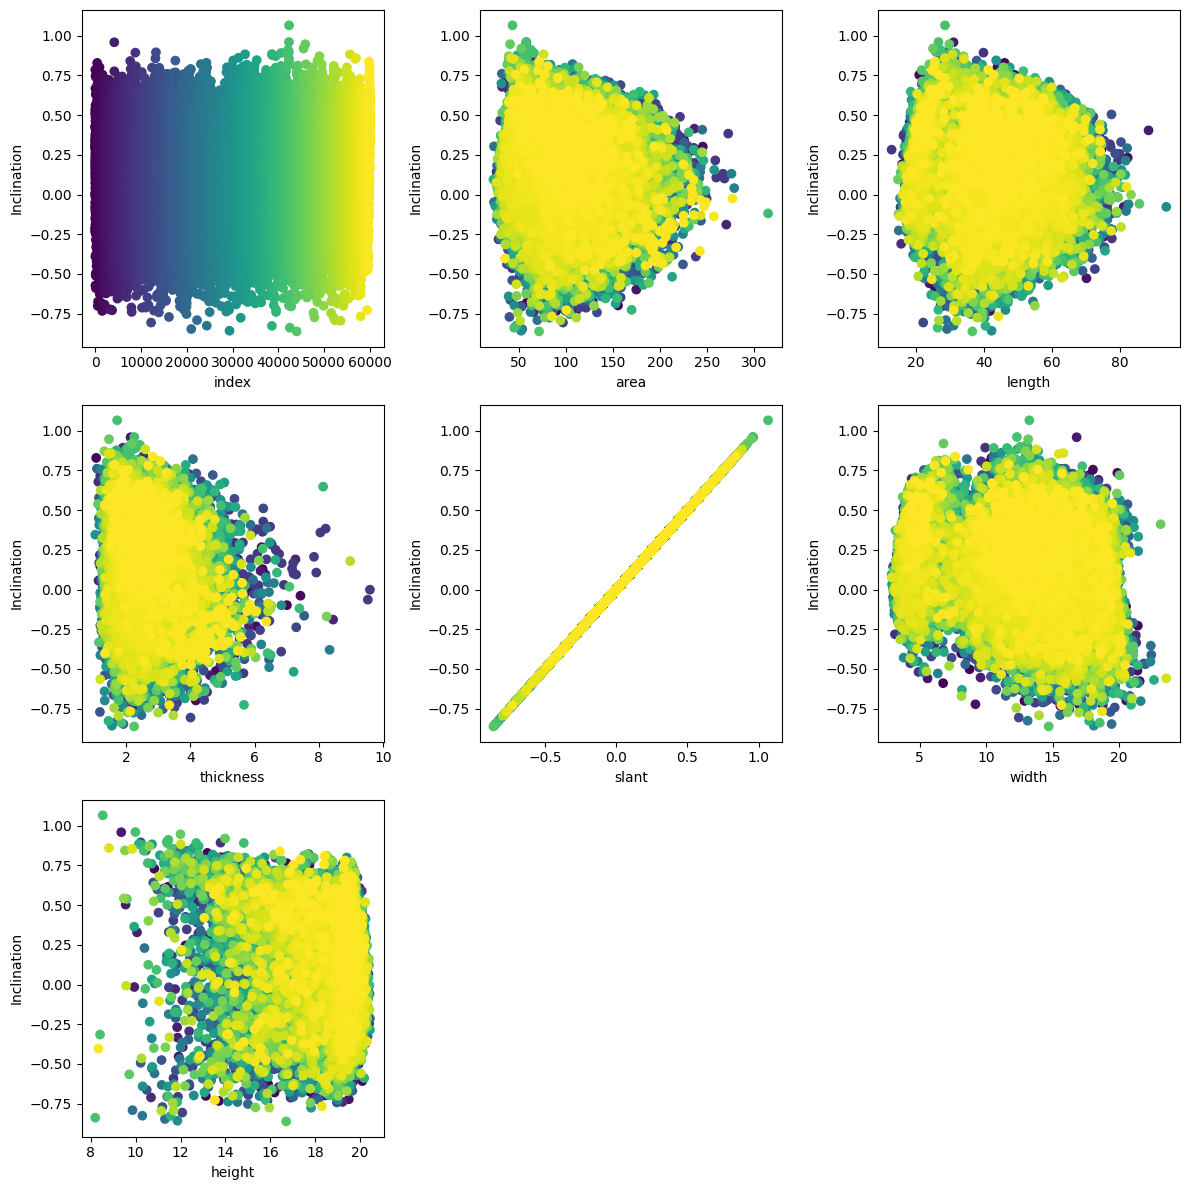

In [9]:
morpho_descriptors = ['index', 'area', 'length', 'thickness', 'slant', 'width', 'height']
plt.figure(figsize=(12, 12))
for i, descriptor in enumerate(morpho_descriptors):
    plt.subplot(3, 3, i + 1)
    plt.scatter(train_morpho[descriptor], train_morpho['slant'], c=train_morpho['index'], cmap='viridis')
    plt.xlabel(descriptor)
    plt.ylabel('Inclination')
plt.tight_layout()
plt.show()

### Normalization

In [10]:
x_train_normalized = x_train / 255.0
x_test_normalized = x_test / 255.0

In [11]:
y_train_labels = y_train.astype(int)
y_test_labels = y_test.astype(int)

## a) Image

2 hidden layer model

In [17]:
K.clear_session()

# Define the MLP model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(28, 28)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.summary()

model.compile(loss='mean_absolute_error', optimizer=Adam())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 28, 128)           3712      
                                                                 
 flatten (Flatten)           (None, 3584)              0         
                                                                 
 dense_1 (Dense)             (None, 32)                114720    
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 118,465
Trainable params: 118,465
Non-trainable params: 0
_________________________________________________________________


In [18]:
model_trained = model.fit(x_train_normalized,
                          train_morpho['slant'],
                          epochs=25, batch_size=128,
                          verbose=1,
                          validation_split=0.2
                        )

Epoch 1/25
375/375 [==============================] - 4s 3ms/step - loss: 0.0324 - val_loss: 0.0166
Epoch 2/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0142 - val_loss: 0.0126
Epoch 3/25
375/375 [==============================] - 1s 2ms/step - loss: 0.0111 - val_loss: 0.0097
Epoch 4/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 5/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0089 - val_loss: 0.0080
Epoch 6/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 7/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0075 - val_loss: 0.0077
Epoch 8/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0072 - val_loss: 0.0080
Epoch 9/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0068 - val_loss: 0.0070
Epoch 10/25
375/375 [==============================] - 2s 4ms/step - loss: 0.0067 - val_loss: 0.0068

In [19]:
pred_mae = model.evaluate(x_test_normalized, test_morpho['slant'])
print("MAE:", pred_mae)


313/313 [==============================] - 1s 2ms/step - loss: 0.0052
MAE: 0.005201239604502916


## b) Labels

In [27]:
#model for image input
input_image = Input(shape=(28, 28))
activation_image = Dense(32, activation='relu')(Flatten()(Dense(64, activation='relu')(input_image)))

#model label input
input_label = Input(shape=(1,))
embedding_label = Embedding(10, 2)(input_label)
activation_label = Dense(16, activation='relu')(Flatten()(embedding_label))

# Concatenate the two inputs
output = Dense(1)(Concatenate()([activation_image, activation_label]))
model_2 = Model(inputs=[input_image, input_label], outputs=output)

model_2.compile(optimizer=Adam(), loss='mean_absolute_error')

model_2.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_14 (Dense)               (None, 28, 64)       1856        ['input_6[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 2)         20          ['input_7[0][0]']                
                                                                                            

In [25]:
model_2_trained = model_2.fit([x_train_normalized, y_train_labels], train_morpho['slant'], epochs=25, batch_size=128, validation_split=0.2)

Epoch 1/25
375/375 [==============================] - 2s 4ms/step - loss: 0.0367 - val_loss: 0.0174
Epoch 2/25
375/375 [==============================] - 1s 4ms/step - loss: 0.0154 - val_loss: 0.0129
Epoch 3/25
375/375 [==============================] - 1s 4ms/step - loss: 0.0115 - val_loss: 0.0141
Epoch 4/25
375/375 [==============================] - 1s 4ms/step - loss: 0.0100 - val_loss: 0.0092
Epoch 5/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0085 - val_loss: 0.0081
Epoch 6/25
375/375 [==============================] - 2s 6ms/step - loss: 0.0077 - val_loss: 0.0074
Epoch 7/25
375/375 [==============================] - 2s 6ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 8/25
375/375 [==============================] - 2s 4ms/step - loss: 0.0070 - val_loss: 0.0067
Epoch 9/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0067 - val_loss: 0.0059
Epoch 10/25
375/375 [==============================] - 1s 4ms/step - loss: 0.0061 - val_loss: 0.0066

In [26]:
pred_mae = model_2.evaluate([x_test_normalized, y_test_labels], test_morpho['slant'])
print("MAE:", pred_mae)

313/313 [==============================] - 1s 2ms/step - loss: 0.0048
MAE: 0.004841526038944721


1/1 [==============================] - 0s 58ms/step


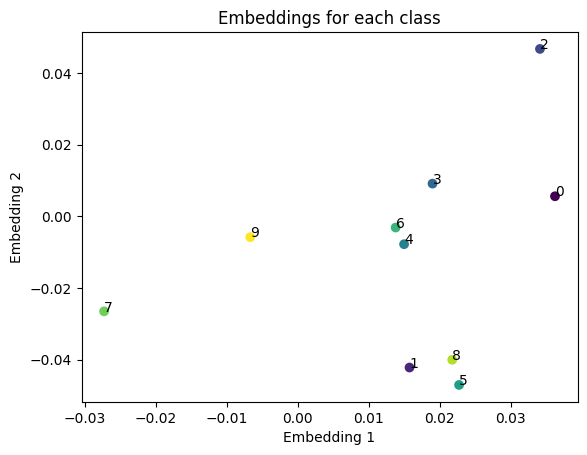

In [29]:
model_embedding = Model(inputs=input_label, outputs=embedding_label)
embeddings = model_embedding.predict(np.arange(len(class_names)))
plt.scatter(embeddings[:,:,0], embeddings[:,:,1], c=np.arange(len(class_names)), cmap='viridis')
for i in range(len(class_names)):
    plt.annotate(i, (embeddings[i,:, 0], embeddings[i,:, 1]))
plt.xlabel('Embedding 1')
plt.ylabel('Embedding 2')
plt.title('Embeddings for each class')
plt.show()

## c) Image and Slant

In [31]:
K.clear_session()

I choose area as it seems to be a good morphologic property to differenciate the classes.

In [32]:
x_train_normalized = x_train / 255.0
x_test_normalized = x_test / 255.0
additional_variable_train = train_morpho['area']
additional_variable_test = test_morpho['area']


In [33]:
#model for image input
input_image = Input(shape=(28, 28))
activation_image = Dense(32, activation='relu')(Flatten()(Dense(64, activation='relu')(input_image)))

#additional model for image input
input_additional = Input(shape=(1,))
activation_additional = Dense(8, activation='relu')(Dropout(0.125)(Dense(16, activation='relu')(BatchNormalization()(input_additional))))

In [36]:
# Concatenate the two inputs
concatenated = Concatenate()([activation_image, activation_additional])
model_3 = Model(inputs=[input_image, input_additional], outputs=Dense(1)(concatenated))

model_3.compile(loss='mean_absolute_error', optimizer=Adam())

model_3.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 1)           4           ['input_2[0][0]']                
 alization)                                                                                       
                                                                                                  
 dense_1 (Dense)                (None, 28, 64)       1856        ['input_1[0][0]']          

In [35]:
model_2_trained = model_3.fit([x_train_normalized, additional_variable_train], train_morpho['slant'], epochs=25, batch_size=128, validation_split=0.2)


Epoch 1/25
375/375 [==============================] - 2s 4ms/step - loss: 0.0443 - val_loss: 0.0188
Epoch 2/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0167 - val_loss: 0.0130
Epoch 3/25
375/375 [==============================] - 2s 4ms/step - loss: 0.0121 - val_loss: 0.0118
Epoch 4/25
375/375 [==============================] - 2s 6ms/step - loss: 0.0100 - val_loss: 0.0093
Epoch 5/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0092 - val_loss: 0.0086
Epoch 6/25
375/375 [==============================] - 3s 8ms/step - loss: 0.0081 - val_loss: 0.0082
Epoch 7/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 8/25
375/375 [==============================] - 2s 6ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 9/25
375/375 [==============================] - 1s 4ms/step - loss: 0.0065 - val_loss: 0.0068
Epoch 10/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0065 - val_loss: 0.0074

In [37]:
# Evaluate the model on the test set
pred_mae = model_3.evaluate([x_test_normalized, additional_variable_test], test_morpho['slant'])
print("MAE:", pred_mae)


313/313 [==============================] - 1s 2ms/step - loss: 0.2654
MAE: 0.2653889060020447
